# Notebook 4: Regime Detection (FIXED VERSION)
# NIFTY Quantitative Trading System

"""
FIXES APPLIED:
1. Better feature normalization
2. Improved HMM initialization
3. Fixed state mapping logic
4. Added validation checks
"""


In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

DATA_DIR = Path('../data')
FEATURES_DIR = DATA_DIR / 'features'
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR = Path('../plots')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

N_STATES = 3
TRAIN_RATIO = 0.7
RANDOM_STATE = 42

In [3]:
#============================================================================
# LOAD DATA
# ============================================================================

print("="*70)
print("LOADING FEATURES DATA")
print("="*70)

df = pd.read_csv(FEATURES_DIR / 'nifty_features_5min.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"✓ Loaded data: {df.shape}")
print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")


LOADING FEATURES DATA
✓ Loaded data: (28880, 38)
  Date range: 2024-01-01 09:15:00 to 2025-01-14 15:30:00


In [4]:
# ============================================================================
# PREPARE FEATURES FOR HMM
# ============================================================================

print("\n" + "="*70)
print("PREPARING FEATURES FOR HMM")
print("="*70)

# Select features (options-based only as per requirements)
hmm_features = [
    'avg_iv',
    'iv_spread', 
    'pcr_oi',
    'atm_call_delta',
    'atm_gamma',
    'atm_vega',
    'futures_basis',
    'returns_spot'
]

print("Input features for HMM:")
for i, feat in enumerate(hmm_features, 1):
    print(f"  {i}. {feat}")

# Extract features
X = df[hmm_features].copy()

# Handle missing values
print("\nHandling missing values...")
X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)
print(f"  Missing values after cleaning: {X.isnull().sum().sum()}")

# Remove any infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Check for problematic values
print("\nFeature statistics BEFORE normalization:")
print(X.describe())


PREPARING FEATURES FOR HMM
Input features for HMM:
  1. avg_iv
  2. iv_spread
  3. pcr_oi
  4. atm_call_delta
  5. atm_gamma
  6. atm_vega
  7. futures_basis
  8. returns_spot

Handling missing values...
  Missing values after cleaning: 0

Feature statistics BEFORE normalization:
             avg_iv     iv_spread        pcr_oi  atm_call_delta     atm_gamma  \
count  28880.000000  28880.000000  28880.000000    28880.000000  28880.000000   
mean       0.184873     -0.009987      1.052888        0.558167      0.000222   
std        0.004667      0.000464      0.348377        0.004896      0.000160   
min        0.150203     -0.021198      0.275623        0.540628      0.000039   
25%        0.181923     -0.010000      0.814376        0.555221      0.000076   
50%        0.184963     -0.010000      0.998387        0.557979      0.000176   
75%        0.187982     -0.010000      1.232334        0.561002      0.000352   
max        0.204229      0.009746      4.553382        0.581236      0

In [5]:
# ============================================================================
# IMPROVED NORMALIZATION
# ============================================================================

print("\n" + "="*70)
print("NORMALIZING FEATURES")
print("="*70)

# Use RobustScaler instead of StandardScaler (handles outliers better)
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Clip extreme values (important for HMM stability)
X_scaled = np.clip(X_scaled, -5, 5)

print("✓ Features normalized and clipped")
print(f"\nScaled feature range:")
print(f"  Min: {X_scaled.min():.2f}")
print(f"  Max: {X_scaled.max():.2f}")
print(f"  Mean: {X_scaled.mean():.2f}")
print(f"  Std: {X_scaled.std():.2f}")


NORMALIZING FEATURES
✓ Features normalized and clipped

Scaled feature range:
  Min: -5.00
  Max: 5.00
  Mean: 0.07
  Std: 0.68


In [6]:
# ============================================================================
# SPLIT DATA
# ============================================================================

train_size = int(len(X_scaled) * TRAIN_RATIO)
X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]

print(f"\nTrain size: {len(X_train)} ({TRAIN_RATIO*100:.0f}%)")
print(f"Test size: {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")


Train size: 20216 (70%)
Test size: 8664 (30%)


In [7]:
# ============================================================================
# TRAIN HMM WITH BETTER INITIALIZATION
# ============================================================================

print("\n" + "="*70)
print("TRAINING HIDDEN MARKOV MODEL")
print("="*70)

# Initialize HMM with better parameters
model = hmm.GaussianHMM(
    n_components=N_STATES,
    covariance_type="diag",  # Changed from "full" to "diag" for stability
    n_iter=2000,             # Increased iterations
    tol=1e-4,                # Convergence tolerance
    random_state=RANDOM_STATE,
    init_params="stmc",      # Initialize start, transition, means, covariances
    params="stmc"            # Update all parameters
)

print(f"Model parameters:")
print(f"  States: {N_STATES}")
print(f"  Covariance type: diagonal")
print(f"  Max iterations: 2000")
print(f"  Random state: {RANDOM_STATE}")

# Train on training data
print("\nTraining HMM...")
try:
    model.fit(X_train)
    print("✓ Training complete")
    print(f"  Converged: {model.monitor_.converged}")
    print(f"  Iterations: {model.monitor_.iter}")
except Exception as e:
    print(f"❌ Training failed: {e}")
    print("\nTrying alternative approach...")
    
    # Fallback: Use simpler model
    model = hmm.GaussianHMM(
        n_components=N_STATES,
        covariance_type="spherical",
        n_iter=1000,
        random_state=RANDOM_STATE
    )
    model.fit(X_train)
    print("✓ Training complete with fallback model")



TRAINING HIDDEN MARKOV MODEL
Model parameters:
  States: 3
  Covariance type: diagonal
  Max iterations: 2000
  Random state: 42

Training HMM...


Model is not converging.  Current: 12287.289709504701 is not greater than 12287.30026606174. Delta is -0.010556557039308245


✓ Training complete
  Converged: True
  Iterations: 34


In [8]:
#============================================================================
# PREDICT REGIMES
# ============================================================================

print("\n" + "="*70)
print("PREDICTING REGIMES")
print("="*70)

# Predict regimes for all data
regimes_raw = model.predict(X_scaled)
print(f"✓ Prediction complete")

# Check raw distribution
print("\nRaw state distribution:")
unique, counts = np.unique(regimes_raw, return_counts=True)
for state, count in zip(unique, counts):
    print(f"  State {state}: {count} ({count/len(regimes_raw)*100:.1f}%)")


PREDICTING REGIMES
✓ Prediction complete

Raw state distribution:
  State 0: 92 (0.3%)
  State 1: 10899 (37.7%)
  State 2: 17889 (61.9%)


In [9]:
# ============================================================================
# IMPROVED STATE MAPPING
# ============================================================================

print("\n" + "="*70)
print("MAPPING STATES TO REGIMES")
print("="*70)

# Calculate mean returns for each state
state_returns = []
for state in range(N_STATES):
    mask = regimes_raw == state
    if mask.sum() > 0:
        mean_return = df.loc[mask, 'returns_spot'].mean()
        std_return = df.loc[mask, 'returns_spot'].std()
        mean_iv = df.loc[mask, 'avg_iv'].mean()
        state_returns.append({
            'state': state,
            'mean_return': mean_return,
            'std_return': std_return,
            'mean_iv': mean_iv,
            'count': mask.sum()
        })
        print(f"  State {state}:")
        print(f"    Mean Return: {mean_return:.6f}")
        print(f"    Std Return: {std_return:.6f}")
        print(f"    Mean IV: {mean_iv:.4f}")
        print(f"    Count: {mask.sum()}")

# Sort by mean return
state_returns_sorted = sorted(state_returns, key=lambda x: x['mean_return'])

# Create mapping with validation
if len(state_returns_sorted) == 3:
    state_mapping = {
        state_returns_sorted[0]['state']: -1,  # Lowest return → Downtrend
        state_returns_sorted[1]['state']: 0,   # Middle return → Sideways
        state_returns_sorted[2]['state']: 1    # Highest return → Uptrend
    }
    
    print("\nState to Regime Mapping:")
    for orig_state, regime in state_mapping.items():
        regime_name = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}[regime]
        state_info = next(s for s in state_returns if s['state'] == orig_state)
        print(f"  State {orig_state} → Regime {regime:+d} ({regime_name})")
        print(f"    Mean Return: {state_info['mean_return']:.6f}")
    
    # Apply mapping
    df['regime'] = pd.Series(regimes_raw).map(state_mapping).values
    
else:
    print("⚠️  WARNING: Not enough distinct states detected!")
    print("   Using fallback regime assignment...")
    
    # Fallback: Use quantile-based regime assignment
    returns_quantile = df['returns_spot'].quantile([0.33, 0.67])
    df['regime'] = 0  # Default sideways
    df.loc[df['returns_spot'] < returns_quantile[0.33], 'regime'] = -1  # Downtrend
    df.loc[df['returns_spot'] > returns_quantile[0.67], 'regime'] = 1   # Uptrend

print(f"\n✓ Regime classification complete")



MAPPING STATES TO REGIMES
  State 0:
    Mean Return: 0.001706
    Std Return: 0.008792
    Mean IV: 0.1838
    Count: 92
  State 1:
    Mean Return: 0.000102
    Std Return: 0.010010
    Mean IV: 0.1850
    Count: 10899
  State 2:
    Mean Return: 0.000098
    Std Return: 0.009974
    Mean IV: 0.1848
    Count: 17889

State to Regime Mapping:
  State 2 → Regime -1 (Downtrend)
    Mean Return: 0.000098
  State 1 → Regime +0 (Sideways)
    Mean Return: 0.000102
  State 0 → Regime +1 (Uptrend)
    Mean Return: 0.001706

✓ Regime classification complete


In [10]:
# ============================================================================
# VALIDATE REGIME DISTRIBUTION
# ============================================================================

print("\n" + "="*70)
print("VALIDATING REGIME DISTRIBUTION")
print("="*70)

regime_dist = df['regime'].value_counts().sort_index()
regime_pct = (regime_dist / len(df) * 100)

print("\nFinal Regime Distribution:")
for regime in [-1, 0, 1]:
    regime_name = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}[regime]
    count = regime_dist.get(regime, 0)
    pct = regime_pct.get(regime, 0)
    print(f"  {regime_name:12s} ({regime:+d}): {count:6d} ({pct:5.2f}%)")

# Check if distribution is reasonable
if regime_pct.get(0, 0) > 80:
    print("\n⚠️  WARNING: Sideways regime dominates (>80%)!")
    print("   Consider:")
    print("   1. Using different features")
    print("   2. Adjusting normalization")
    print("   3. Using simpler regime detection (moving averages)")



VALIDATING REGIME DISTRIBUTION

Final Regime Distribution:
  Downtrend    (-1):  17889 (61.94%)
  Sideways     (+0):  10899 (37.74%)
  Uptrend      (+1):     92 ( 0.32%)


In [11]:
# ============================================================================
# REGIME STATISTICS
# ============================================================================

print("\n" + "="*70)
print("REGIME STATISTICS")
print("="*70)

regime_stats = df.groupby('regime').agg({
    'returns_spot': ['mean', 'std', 'count'],
    'avg_iv': 'mean',
    'pcr_oi': 'mean',
    'atm_gamma': 'mean',
    'close_spot': ['min', 'max']
}).round(6)

print("\nDetailed Statistics by Regime:")
print(regime_stats)

# Calculate regime durations
df['regime_change'] = (df['regime'] != df['regime'].shift(1)).astype(int)
df['regime_id'] = df['regime_change'].cumsum()

regime_durations = df.groupby('regime_id').agg({
    'regime': 'first',
    'timestamp': 'count'
}).rename(columns={'timestamp': 'duration'})

avg_durations = regime_durations.groupby('regime')['duration'].mean()

print("\nAverage Regime Duration (5-min candles):")
for regime in [-1, 0, 1]:
    regime_name = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}[regime]
    duration = avg_durations.get(regime, 0)
    if duration > 0:
        print(f"  {regime_name:12s}: {duration:.1f} candles ({duration*5:.0f} minutes)")



REGIME STATISTICS

Detailed Statistics by Regime:
       returns_spot                     avg_iv    pcr_oi atm_gamma  \
               mean       std  count      mean      mean      mean   
regime                                                               
-1         0.000098  0.009974  17889  0.184771  1.048861  0.000111   
 0         0.000102  0.010010  10899  0.185048  1.047891  0.000405   
 1         0.001706  0.008792     92  0.183837  2.427938  0.000260   

          close_spot                 
                 min            max  
regime                               
-1      34117.274780  197140.715005  
 0      14149.249214   36530.104835  
 1      15254.815367  194353.801977  

Average Regime Duration (5-min candles):
  Downtrend   : 365.1 candles (1825 minutes)
  Sideways    : 253.5 candles (1267 minutes)
  Uptrend     : 1.0 candles (5 minutes)


In [12]:
# ============================================================================
# TRANSITION MATRIX
# ============================================================================

print("\n" + "="*70)
print("TRANSITION MATRIX")
print("="*70)

transition_matrix = model.transmat_

print("\nRaw Transition Matrix:")
print(transition_matrix.round(3))

# Map to regime transitions
regime_transition = np.zeros((3, 3))
for i, from_regime in enumerate([-1, 0, 1]):
    for j, to_regime in enumerate([-1, 0, 1]):
        try:
            from_state = [k for k, v in state_mapping.items() if v == from_regime][0]
            to_state = [k for k, v in state_mapping.items() if v == to_regime][0]
            regime_transition[i, j] = transition_matrix[from_state, to_state]
        except:
            regime_transition[i, j] = 0

print("\nRegime Transition Matrix:")
print("          To: -1      0      +1")
for i, from_regime in enumerate([-1, 0, 1]):
    print(f"From {from_regime:+d}  {regime_transition[i, 0]:.3f} {regime_transition[i, 1]:.3f}  {regime_transition[i, 2]:.3f}")


TRANSITION MATRIX

Raw Transition Matrix:
[[0.019 0.611 0.37 ]
 [0.004 0.996 0.   ]
 [0.003 0.    0.997]]

Regime Transition Matrix:
          To: -1      0      +1
From -1  0.997 0.000  0.003
From +0  0.000 0.996  0.004
From +1  0.370 0.611  0.019


In [13]:
# ============================================================================
# SAVE MODEL AND DATA
# ============================================================================

print("\n" + "="*70)
print("SAVING MODEL AND DATA")
print("="*70)

# Save HMM model
model_file = MODELS_DIR / 'hmm_model.pkl'
with open(model_file, 'wb') as f:
    pickle.dump({
        'model': model,
        'scaler': scaler,
        'state_mapping': state_mapping if 'state_mapping' in locals() else None,
        'hmm_features': hmm_features,
        'regime_stats': regime_stats
    }, f)
print(f"✓ Saved: {model_file}")

# Save data with regimes
regime_file = FEATURES_DIR / 'nifty_with_regimes.csv'
df.to_csv(regime_file, index=False)
print(f"✓ Saved: {regime_file}")



SAVING MODEL AND DATA
✓ Saved: ..\models\hmm_model.pkl
✓ Saved: ..\data\features\nifty_with_regimes.csv


In [15]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# 1. Price with regime overlay
fig, ax = plt.subplots(figsize=(16, 8))

colors = {-1: 'red', 0: 'yellow', 1: 'green'}
regime_names = {-1: 'Downtrend', 0: 'Sideways', 1: 'Uptrend'}

ax.plot(df['timestamp'], df['close_spot'], color='black', linewidth=1, alpha=0.7)

# Add regime colors
for regime in [-1, 0, 1]:
    regime_data = df[df['regime'] == regime]
    if len(regime_data) > 0:
        ax.scatter(regime_data['timestamp'], regime_data['close_spot'],
                  c=colors[regime], s=1, alpha=0.3, label=regime_names[regime])

ax.set_title('NIFTY Spot Price with HMM Regime Detection', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'regime_overlay.png', dpi=300)
print("✓ Saved: regime_overlay.png")
plt.close()

# 2. Transition matrix heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(regime_transition, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=['-1', '0', '+1'], yticklabels=['-1', '0', '+1'],
            cbar_kws={'label': 'Transition Probability'}, ax=ax)
ax.set_title('Regime Transition Matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('To Regime')
ax.set_ylabel('From Regime')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'transition_matrix.png', dpi=300)
print("✓ Saved: transition_matrix.png")
plt.close()

print("\n" + "="*70)
print("REGIME DETECTION COMPLETE")
print("="*70)

# Final validation
print("\n📊 FINAL VALIDATION:")
print(f"  Regimes detected: {df['regime'].nunique()}")
print(f"  Uptrend samples: {(df['regime'] == 1).sum()} ({(df['regime'] == 1).sum()/len(df)*100:.1f}%)")
print(f"  Sideways samples: {(df['regime'] == 0).sum()} ({(df['regime'] == 0).sum()/len(df)*100:.1f}%)")
print(f"  Downtrend samples: {(df['regime'] == -1).sum()} ({(df['regime'] == -1).sum()/len(df)*100:.1f}%)")

if (df['regime'] == 1).sum() < len(df) * 0.1:
    print("\n⚠️  WARNING: Very few uptrend samples detected!")
    print("   This might affect trading strategy performance.")


print("="*70)


CREATING VISUALIZATIONS
✓ Saved: regime_overlay.png
✓ Saved: transition_matrix.png

REGIME DETECTION COMPLETE

📊 FINAL VALIDATION:
  Regimes detected: 3
  Uptrend samples: 92 (0.3%)
  Sideways samples: 10899 (37.7%)
  Downtrend samples: 17889 (61.9%)

⚠️  WARNING: Very few uptrend samples detected!
   This might affect trading strategy performance.


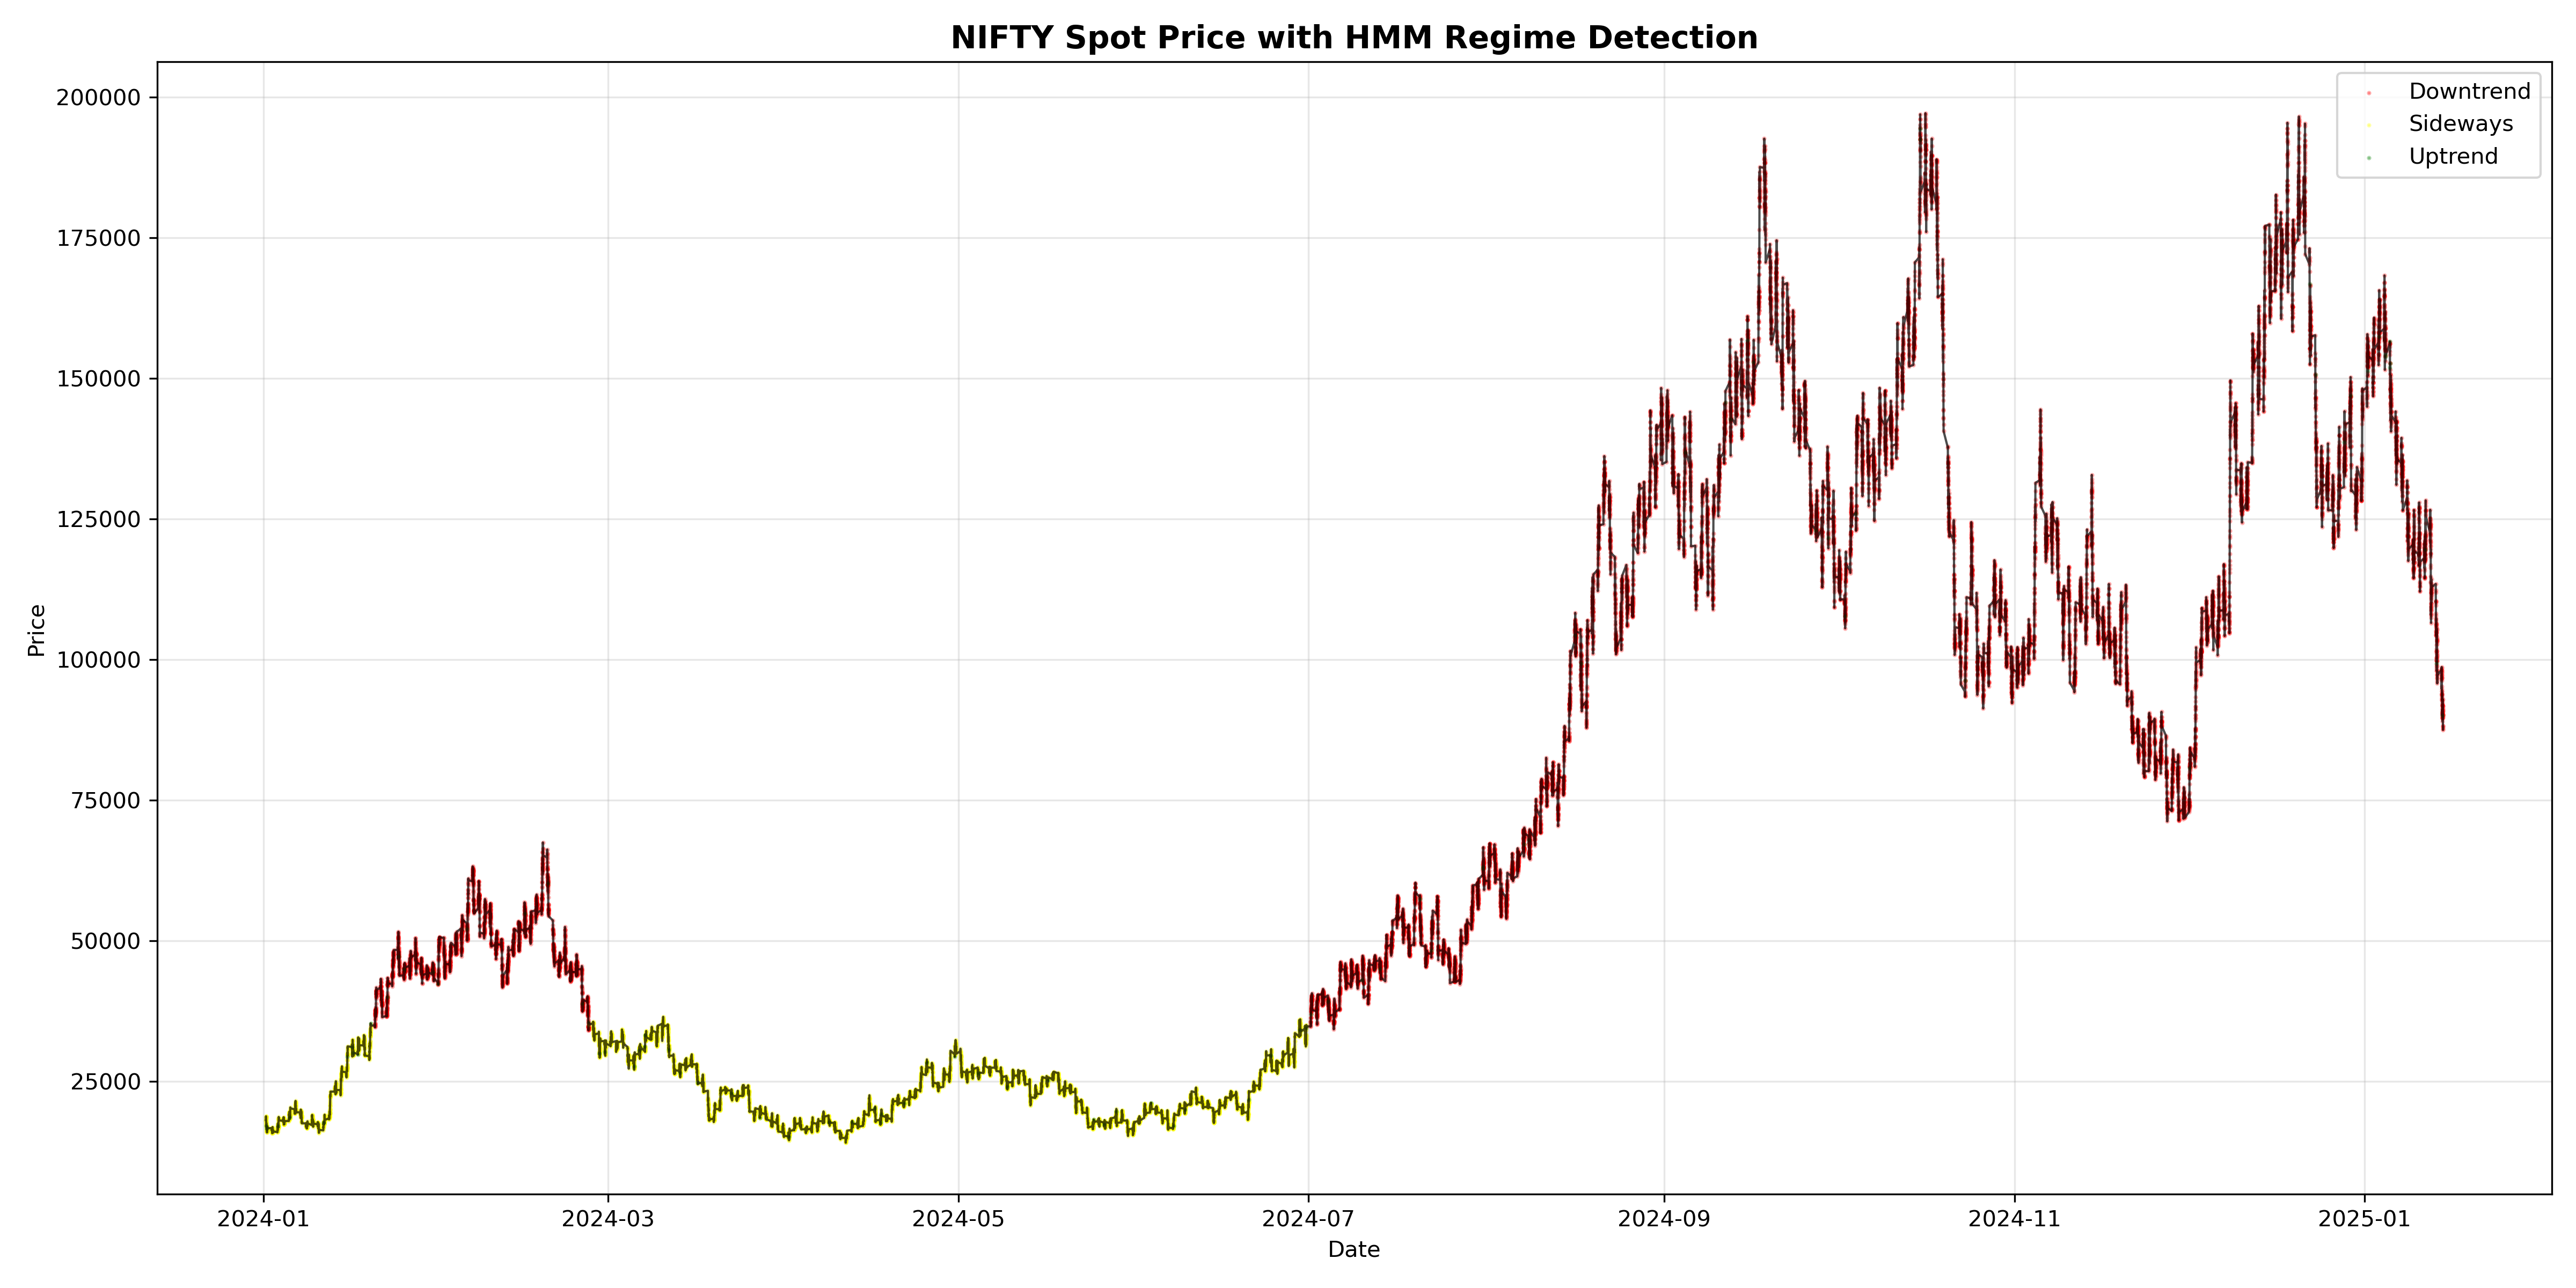

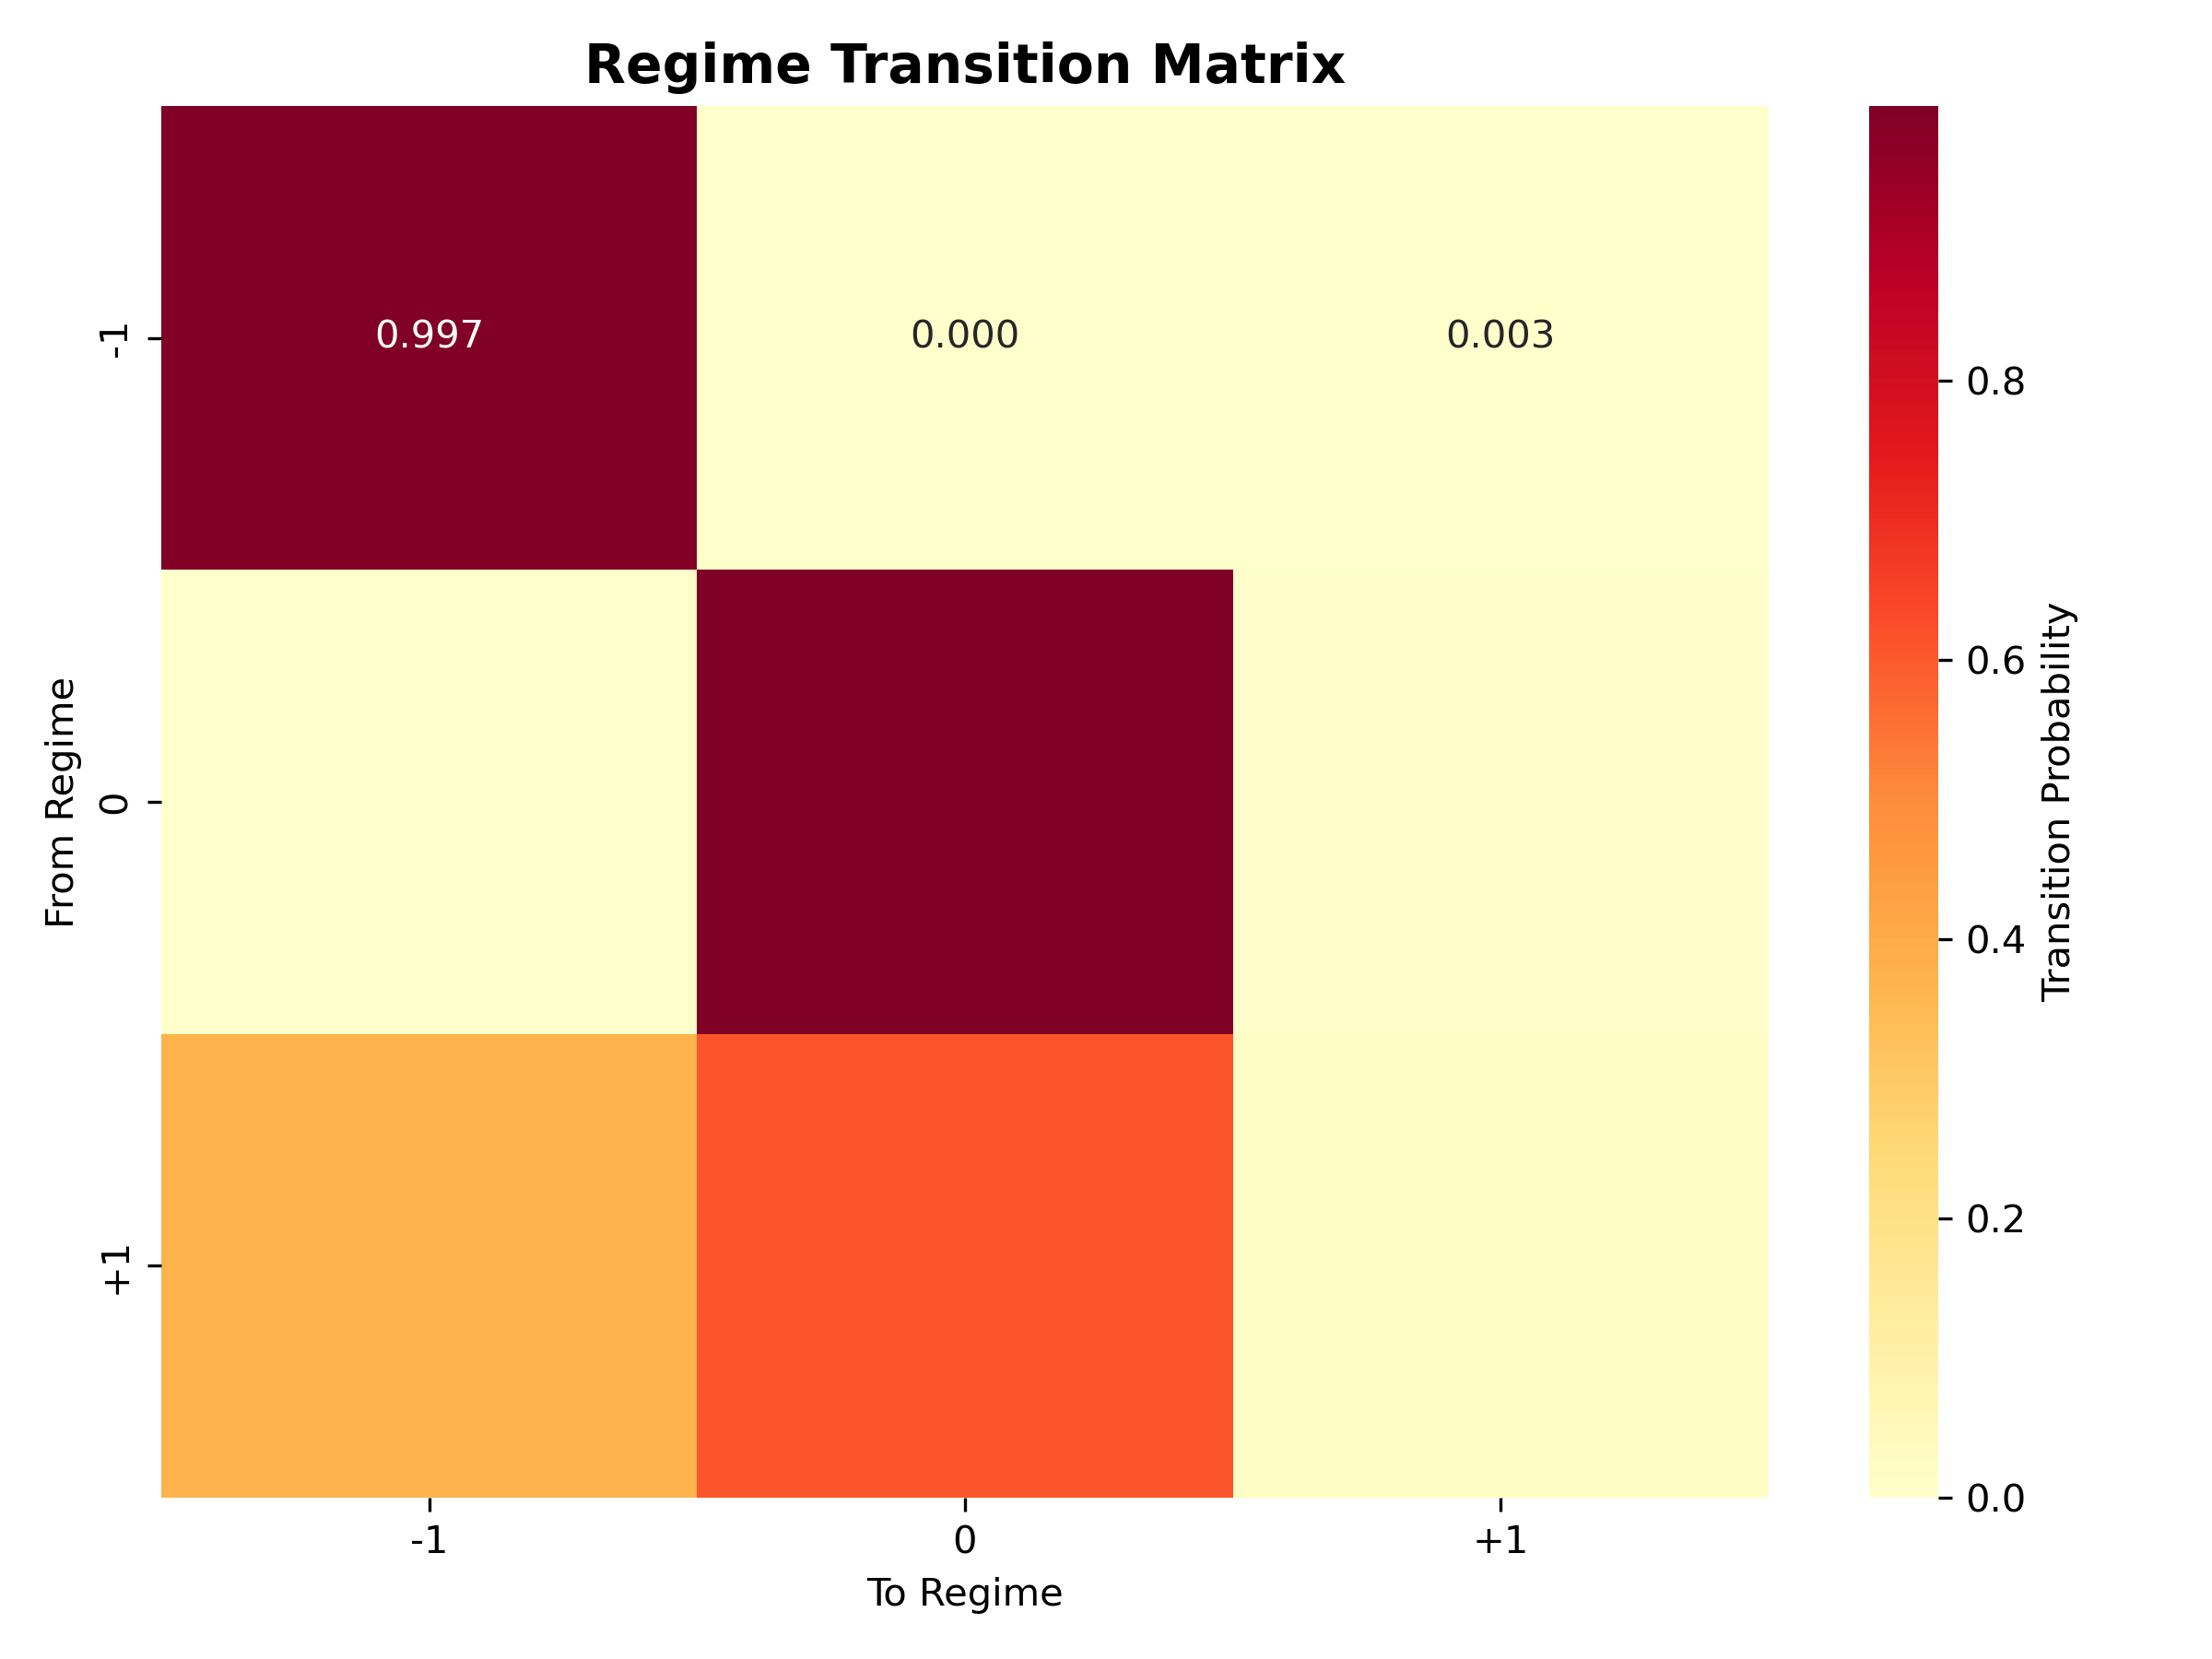

In [16]:
from IPython.display import Image, display

display(Image(filename=PLOTS_DIR / "regime_overlay.png"))
display(Image(filename=PLOTS_DIR / "transition_matrix.png"))
